In [1]:
import os
import sys
import cv2
import wget
import glob
import wandb
import shutil
import numpy as np
import numpy.testing as npt
import torch
import torchvision
import matplotlib.pyplot as plt
from torchvision.transforms import v2
from torchvision.datasets import VisionDataset
from torch.utils.data import Subset, DataLoader
from torchvision.datasets.utils import check_integrity, download_and_extract_archive, download_url, verify_str_arg
from typing import Any, Callable, Dict, List, Optional, Tuple, Union
import shutil
from PIL import Image,ImageFile
import glob

In [2]:
torch.multiprocessing.set_start_method('spawn')
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device = torch.device('cpu') 
# Delete this line if you want to use GPU
# ISSUE: https://github.com/Lightning-AI/lit-gpt/issues/138 for the last part of this laboratory, everything else should be fine
torch.set_default_device(device)

With: [Labeled Faces in the Wild dataset](https://vis-www.cs.umass.edu/lfw/) facial images, each pixel is background, skin, and hair. Can be found [here](https://vis-www.cs.umass.edu/lfw/part_labels/): 3k samples

Much larger dataset: [CelebA-MaskHQ dataset](https://github.com/switchablenorms/CelebAMask-HQ): 30k samples

| Dataset  | Number of samples  |  Link |
|---|---|---|
| LFWParts | 2927 | https://vis-www.cs.umass.edu/lfw/part_labels/ |
| CelebAMaskHQ | 30000 | https://github.com/switchablenorms/CelebAMask-HQ |

In [3]:
# Class arhchitecture inspired by https://pytorch.org/vision/main/_modules/torchvision/datasets/oxford_iiit_pet.html

class _LFW(torch.utils.data.Dataset):
    files = {
        "people_funneled": ("http://vis-www.cs.umass.edu/lfw/lfw-funneled.tgz", "images.tgz", "1b42dfed7d15c9b2dd63d5e5840c86ad"),
        "segmentation_mask": ("https://vis-www.cs.umass.edu/lfw/part_labels/parts_lfw_funneled_gt_images.tgz", "segmentations.tgz", "3e7e26e801c3081d651c8c2ef3c45cfc"),
        "train": ("https://vis-www.cs.umass.edu/lfw/part_labels/parts_train.txt", "train.txt", None),
        "test": ("https://vis-www.cs.umass.edu/lfw/part_labels/parts_test.txt", "test.txt", None),
    }
    
    def __init__(self, base_folder: str, transform, download: bool=True):
        super().__init__()
        self._base_folder = base_folder
        self.transform = transform
        self.data: List[Any] = []
        self.split = None
        self.images_dir = os.path.join(self._base_folder, "lfw_funneled")
        self.segmentations_dir = os.path.join(self._base_folder, "parts_lfw_funneled_gt_images")
        
        if download:
            self._download()
        if not self._check_integrity(): # Optional, just checking if everything is ok with the data
            raise RuntimeError("Data not found or corrupted.")
    
    def _load_image(self, path: str):
        with Image.open(path) as image:
            return image.convert("RGB")

    def _load_segmentation(self, path: str):
        with Image.open(rf"{path}") as image:
            return image.convert("L")
    
    def __len__(self) -> int:
        return len(self.data)

    def __getitem__(self, index: int) -> Tuple[Any, Any]:
        image = self._load_image(self.data[index][0])
        segmentation = self._load_segmentation(self.data[index][1])
        if self.transform is not None:
            image = self.transform(image)
            segmentation = self.transform(segmentation)
        return image, segmentation
    
    def _check_integrity(self) -> bool:
        ok = True
        for file in self.files.values():
            if file[2] == None:
                ok&= os.path.exists(os.path.join(self._base_folder, file[1]))
                continue
            ok &= check_integrity(os.path.join(self._base_folder, file[1]), file[2])
        if not ok:
            return False
        return True
    
    def _download(self):
        if self._check_integrity():
            print("Dataset already downloaded and verified")
            return

        for url, filename, md5 in self.files.values():
            if md5 == None:
                download_url(url, root=self._base_folder, filename=filename, md5=md5)
                continue
            if not check_integrity(os.path.join(self._base_folder, filename), md5):
                download_and_extract_archive(url, download_root=self._base_folder, filename=filename, md5=md5)

class LFWDataset(_LFW):
    def __init__(self, base_folder: str, transform, download: bool=True, split="train"):
        super().__init__(base_folder, transform, download)
        self._image_plus_segmentation_path = os.path.join(self._base_folder, f"{split}.txt")
        self._load_data()
        self.transforms = transform
    
    def _load_data(self):
        self.data = [] # These are just the paths to the images and segmentations
        with open(self._image_plus_segmentation_path, "r") as f:
            for line in f.readlines():
                name, index = line.strip().split(" ")
                if len(index) != 4:
                    index = "0"*(4-len(index)) + index
                name_image = os.path.join(self.images_dir, name, f"{name}_{index}.jpg")
                segmentation_image = os.path.join(self.segmentations_dir, f"{name}_{index}.ppm")
                if os.path.exists(name_image) and os.path.exists(segmentation_image):
                    self.data.append((name_image, segmentation_image))

In [4]:
transforms = v2.Compose([v2.Resize(128), v2.CenterCrop(224), v2.ToTensor().to(device)])
target_transforms = v2.Compose([v2.Resize(128), v2.CenterCrop(224), v2.ToTensor().to(device)])
train_dataset = LFWDataset(base_folder='./data', split="train", download=True, transform=transforms)
validation_dataset = LFWDataset(base_folder='./data', split="test", download=True, transform=transforms)

/usr/local/lib/python3.10/dist-packages/torchvision/transforms/v2/_deprecated.py:43: UserWarning: The transform `ToTensor()` is deprecated and will be removed in a future release. Instead, please use `v2.Compose([v2.ToImage(), v2.ToDtype(torch.float32, scale=True)])`.
  warnings.warn(


Dataset already downloaded and verified
Dataset already downloaded and verified


In [5]:
# code /root/.jupyter/jupyter_notebook_config.py
# c.NotebookApp.max_buffer_size = 20000000000
# 9GB RAM, Issue on github PPM takes lot of ram
# Performance improvement, should be used only with small datasets, delete cell if you don't have enough RAM, should work OOTB
class RamDataset(torch.utils.data.Dataset):
    def __init__(self, dataset: LFWDataset):
        data_loader = DataLoader(dataset, batch_size=len(dataset))
        self._images, self._segmentations = next(iter(data_loader))
    def __getitem__(self, index):
        return self._images[index], self._segmentations[index]
    def __len__(self):
        return self._images.shape[0]

train_dataset = RamDataset(train_dataset)
validation_dataset = RamDataset(validation_dataset)

Analyze the dataset

Number of samples in the train_dataset:  1500
Shape of the first image:  torch.Size([3, 224, 224])
Shape of the segmentation of first image:  torch.Size([1, 224, 224])


Text(0.5, 1.0, 'Segmentation')

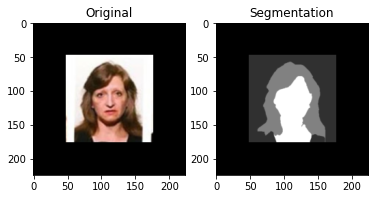

In [6]:
print("Number of samples in the train_dataset: ", len(train_dataset))
print("Shape of the first image: ", train_dataset[0][0].shape)
print("Shape of the segmentation of first image: ", train_dataset[0][1].shape)
first_image = train_dataset[0][0].cpu().numpy().transpose(1, 2, 0)
first_image_segmentation = train_dataset[0][1].cpu().numpy().transpose(1, 2, 0)
plt.subplot(1, 2, 1).imshow(first_image)
plt.title(f"Original")
plt.subplot(1, 2, 2).imshow(first_image_segmentation, cmap="gray")
plt.title(f"Segmentation")

In [7]:
learning_rate = 1e-2
weight_decay = 1e-4
batch_size = 2
number_of_epochs = 10

In [8]:
training_loader, validation_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False, generator=torch.Generator(device=device)), DataLoader(validation_dataset, batch_size=batch_size, shuffle=False, generator=torch.Generator(device=device))

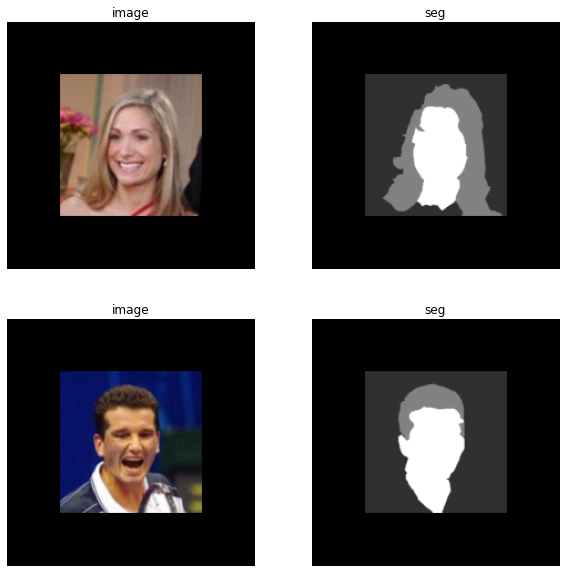

In [9]:
for i_batch, (images, segmentations) in enumerate(validation_loader):
    rows, cols = batch_size, 2
    figure = plt.figure(figsize=(10, 10))

    for i in range(0, batch_size):
        figure.add_subplot(rows, cols, 2*i+1).imshow(images[i].cpu().numpy().transpose(1, 2, 0))
        plt.title('image')
        plt.axis("off")
        figure.add_subplot(rows, cols, 2*i+2).imshow(segmentations[i].cpu().numpy().transpose(1, 2, 0), cmap="gray")
        plt.title('seg')
        plt.axis("off")
    plt.show()
    break


`Model` architecture from [U-Net](https://arxiv.org/abs/1505.04597)

The output depth the number of pixel classes (3: background, skin, hair)

`The downsampling path` repeated convolutions, ReLU and a max pooling operation. At each downsampling step we double the number of feature channels. We'll use a convolutional neural network from the pretrained torchvision models.

`The upsampling path` convolutional transpose layer ([ConvTranspose2d](https://pytorch.org/docs/stable/generated/torch.nn.ConvTranspose2d.html)), concatenation with the correspondingly cropped feature map from the downsampling path, two convolutions, each followed by a ReLU. The cropping is necessary due to the loss of border pixels in every convolution.

<img src="https://miro.medium.com/max/1400/1*J3t2b65ufsl1x6caf6GiBA.png" style="width:40vw; margin-left:20vw"/>

Implement an upsampling block: transposed convolution, a batch normalization block and a ReLu activation.

Remember, the output size $W_o$ of a transposed convolutional layer is:  
\begin{equation}
W_o = (W_i - 1) \cdot S - 2P + F
\end{equation},

`W` size of the input

`S` stride

`P` padding

`F` the filter size

In [10]:
def upsample_block(x, number_of_filters, filter_size, stride = 2):
    output_channels = x.shape[1] // 2
    x = torch.nn.ConvTranspose2d(in_channels=x.shape[1], out_channels=output_channels, kernel_size=filter_size, stride=stride)(x)
    x = torch.nn.BatchNorm2d(x.shape[1])(x)
    x = torch.nn.ReLU()(x)
    return x

In [11]:
in_layer = torch.rand((32, 32, 128, 128))

filter_size = 4
number_of_filters = 16

expected_shapes = [
    (32, 16, 258, 258),
    (32, 16, 512, 512),
    (32, 16, 1020, 1020)
]
strides = [2, 4, 8]

for expected_shape, stride in zip(expected_shapes, strides):
    x = upsample_block(in_layer, number_of_filters, filter_size, stride)
    print('in shape: ', in_layer.shape, ' upsample with filter size ', filter_size, '; stride ', stride, ' -> out shape ', x.shape)
    npt.assert_array_equal(x.shape, expected_shape)

in shape:  torch.Size([32, 32, 128, 128])  upsample with filter size  4 ; stride  2  -> out shape  torch.Size([32, 16, 258, 258])
in shape:  torch.Size([32, 32, 128, 128])  upsample with filter size  4 ; stride  4  -> out shape  torch.Size([32, 16, 512, 512])
in shape:  torch.Size([32, 32, 128, 128])  upsample with filter size  4 ; stride  8  -> out shape  torch.Size([32, 16, 1020, 1020])


`Expected output:`

in shape:  torch.Size([32, 32, 128, 128])  upsample with filter size  4 ; stride  2  -> out shape  torch.Size([32, 16, 258, 258])

in shape:  torch.Size([32, 32, 128, 128])  upsample with filter size  4 ; stride  4  -> out shape  torch.Size([32, 16, 512, 512])

in shape:  torch.Size([32, 32, 128, 128])  upsample with filter size  4 ; stride  8  -> out shape  torch.Size([32, 16, 1020, 1020])

`wandb` experiment tracking and visualization tool which allows you to easily track, visualize, and collaborate on machine learning experiments.
[official docs](https://wandb.ai/). Tutorial: [link](https://docs.wandb.ai/guides/integrations/pytorch).

`wandb sweeps` automate hyperparameter tuning [official docs](https://docs.wandb.ai/guides/sweeps). Need YAML files config, and will display the results a dashboard.